In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from scipy.special import erf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors

### Tracker toy model

Muon decaying at (x=0,z), producing positron with momentum (px,pz). 8 layers at given z (infinite in x) that will return x position (Gaussian). $\vec{B} = B\hat{y}$

Since the Lorentz force only acts perpendicular to the direction of motion, $|v|$ and $\gamma$ don't change, and the time derivative is simply
$\frac{d\vec{v}}{dt} = \frac{q}{\gamma m} (\vec{v} \times \vec{B}) = \frac{qB}{\gamma m} (v_x \hat{z} - v_z\hat{x})$

$v_x = A\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$v_z = A\cos(\frac{qB}{\gamma m} t + \phi)$

$|v|^2 = v_x^2 + v_z^2 = A^2$<br/>
$p_x = |p|\sin(\frac{qB}{\gamma m} t + \phi)$<br/>
$p_z = |p|\cos(\frac{qB}{\gamma m} t + \phi)$

$\tan \phi = \frac{v_x(0)}{v_z(0)} = \frac{p_x(0)}{p_z(0)}$

$x = \int_0^T v_x dt = -\frac{\gamma m}{qB} |v| (\cos(\frac{qB}{\gamma m} T + \phi) - \frac{v_z(0)}{|v|})$<br/>
$z = \int_0^T v_z dt = \frac{\gamma m}{qB} |v| (\sin(\frac{qB}{\gamma m} T + \phi) - \frac{v_x(0)}{|v|})$

$z$ is fixed, so<br/>
$T = \frac{\gamma m}{qB}(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|}) - \phi)$

$x = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\cos(\arcsin(\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})) = \frac{\gamma m v_z(0)}{qB} - \frac{\gamma m|v|}{qB}\sqrt{1 - (\frac{qBz +\gamma mv_x(0)}{\gamma m |v|})^2} = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2|v|^2 - (qBz +\gamma mv_x(0))^2}$<br/>
$x = \frac{\gamma m v_z(0)}{qB} - \frac{1}{qB}\sqrt{\gamma^2m^2v_z^2(0) - q^2B^2z^2 -2qBz\gamma mv_x(0)} = \frac{p_z(0)}{qB} - \frac{1}{qB}\sqrt{p_z^2(0) - q^2B^2z^2 -2qBzp_x(0)}$

Change to use $|p|(0) = p$ and initial angle $\phi$ (from the z-axis):<br/>
$x = \frac{p\cos(\phi)}{qB} - \frac{1}{qB}\sqrt{p^2\cos^2(\phi) - q^2B^2z^2 -2qBzp\sin(\phi)}$

In [2]:
is_full_p = False

#leave out e in momentum calc, and q's above

c = constants.c
#e = constants.e
B = 1.45
#phi = lambda vx,vz: np.arctan2(vx,vz)
N_det = 8
det_zs = np.linspace(0,(N_det-1)*0.12,N_det) #z-layers
l_bin = 5e-3
l_gap = 1e-3

def calc_x(z,p,phi):
    # p is in GeV -> *1e9/c
    if not is_full_p: p = p*1e9/c
    sq = p**2*np.cos(phi)**2 - B**2*z**2 - 2*B*z*p*np.sin(phi)
    sq = np.sqrt(sq)

    return (p*np.cos(phi) - sq)/B

#x position is normal distribution
x_hit = lambda x,sigma: stats.norm(loc=x, scale=sigma)

#number of observed hits is poisson distribution
#obs_hits = lambda N: stats.poisson(mu=N)


#z_toy = -0.217#-0.017
z_toy = -0.053
#p_toy = 1.9
p_toy = 2.45
if is_full_p: p_toy *= 1e9/c
#phi_toy = 0.25
phi_toy = 0.14

sigma = 3e-4

[0.01968015 0.05590199 0.10726634 0.17619791 0.26686027 0.38709087
 0.55492327 0.84282955]


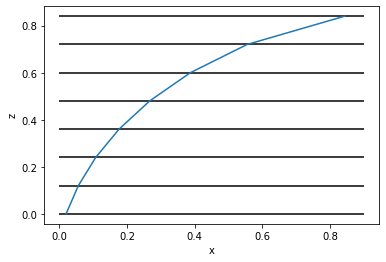

In [3]:
test = calc_x(det_zs+0.1,0.5,0.15)
print(test)
plt.plot(test,det_zs)
plt.hlines(det_zs,0,0.9)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

In [3]:
def generate_events(N_events, z, p, phi):
    '''
    generates event
    
    Parameters:
    
    z : float
        Vertex position
    p : float
        Initial momentum
    phi : float
        Initial angle (with z-axis)
        
    Returns:
    
    xs : numpy array
        observed x-position per detector
    '''
    
    xs = np.zeros((N_events,N_det))
    dist = det_zs-z
    x_exp = calc_x(dist,p,phi)
    for i in range(N_det):
        if np.isnan(x_exp[i]): pass #need to handle this later, set to -1?
        x_meas = x_hit(x_exp[i],sigma).rvs(N_events)
        #let's say 0 is in middle of gap -> first center is 3mm, 2nd is 9, 3rd is 15 etc
        #lower edge: (n-1)*6mm + 0.5mm = n*6 - 5.5
        #upper edge: n*6 - 0.5
        #first check what's the closest lower edge
        n = (x_meas + 5.5e-3)//6e-3
        centers = n*6e-3 - 3e-3
        idx = (x_meas>n*6e-3 - 0.5e-3)
        xs[~idx,i] = centers[~idx]
    if N_events <= 1: xs = xs.flatten()
    return xs

#toy MC
def MC_events(N_events, zlims=(-0.5, -0.001), plims=(1.5,3), phi_lims=(0,np.pi/8)):
    '''
    sample source parameters from uniform distribution of x, p, and phi #isn't really uniform dist
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
        
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array z,p,phi
    # p is in GeV -> *1e9/c
    

    z = np.random.uniform(*zlims, N_events)
    #z = stats.truncnorm(-0.5/0.15,(0.5-1e-3)/0.15,loc=-0.5,scale=0.15).rvs(N_events)
    p = np.random.uniform(*plims, N_events)
    #p = stats.truncnorm(-0.75/0.25,0.75/0.25,loc=2.25,scale=0.25).rvs(N_events)
    if is_full_p: p *= 1e9/c
    phi = np.random.uniform(*phi_lims, N_events)
    #phi = stats.truncnorm(-0.2/0.05,0.2/0.05,loc=0.2,scale=0.05).rvs(N_events)

    truth = np.vstack([z, p, phi]).T

    events = []

    for i in range(N_events):
        events.append(generate_events(1,z[i], p[i], phi[i]))

    return events, truth

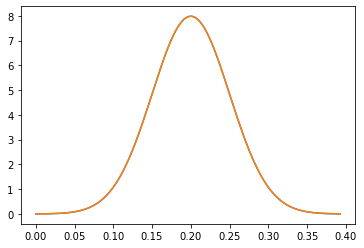

In [25]:
norm = stats.norm(loc=0.2,scale=0.05)
tnorm = stats.truncnorm(-0.2/0.05,0.2/0.05,loc=0.2,scale=0.05)
times = np.linspace(0,np.pi/8, 1000)
plt.plot(times,norm.pdf(times))
plt.plot(times,tnorm.pdf(times))
plt.show()

In [4]:
def plot_event(x_meas,z,p,phi):
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title('hit locations')
    ax.set_xlabel('x')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    x_exp = calc_x(det_zs-z,p,phi)
    for i, z_det in enumerate(det_zs):
        #expectation
        x_dist = x_hit(x_exp[i],sigma) #put in *10 for visibility
        mu = x_dist.mean()
        std = x_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, x_dist.pdf(times),label=f'z={100*det_zs[i]:.0f} cm')
        
        #measured
        if x_meas[i]>0:
            ax.bar(x_meas[i], 50, width=5e-3, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

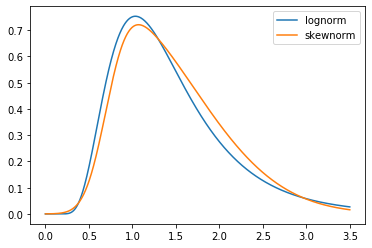

In [133]:
lnorm = stats.lognorm(0.5,loc=0.1,scale=1.2)
snorm = stats.skewnorm(5,loc=0.7,scale=1)
times = np.linspace(0,3.5, 1000)
plt.plot(times,lnorm.pdf(times),label='lognorm')
plt.plot(times,snorm.pdf(times),label='skewnorm')
plt.legend()
plt.show()

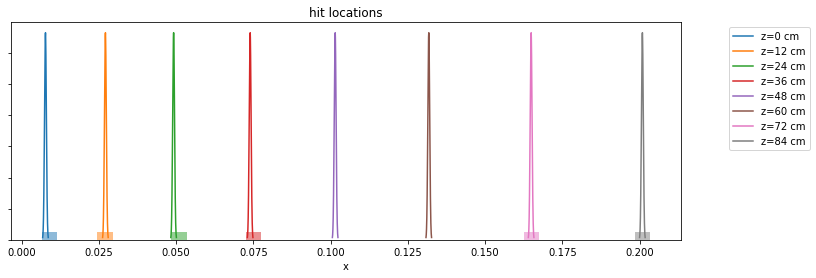

In [5]:
ev = generate_events(1,z_toy,p_toy,phi_toy)
plot_event(ev,z_toy,p_toy,phi_toy)

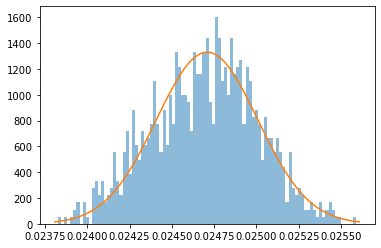

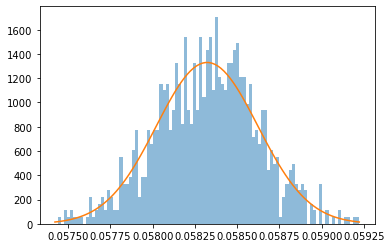

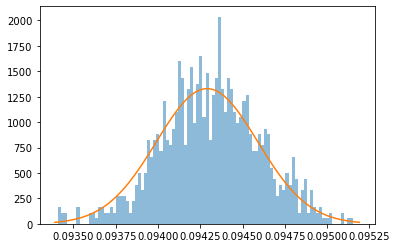

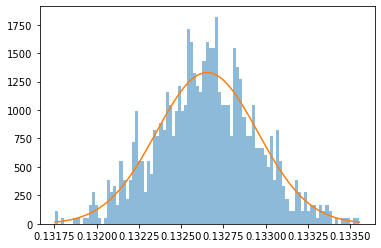

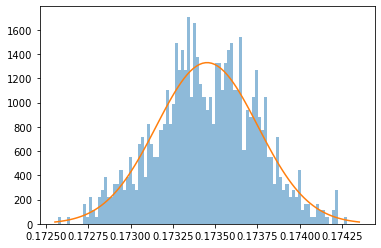

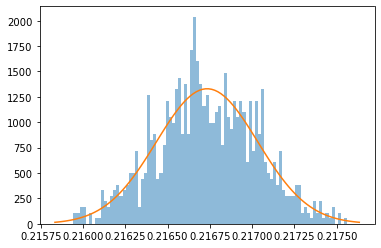

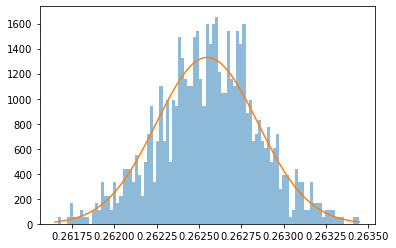

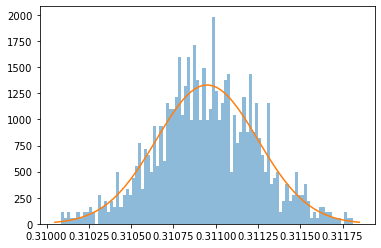

In [10]:
test_n = 1000
test_evs = generate_events(test_n,z_toy,p_toy,phi_toy)

x_exp = calc_x(det_zs-z_toy,p_toy,phi_toy)

for i in range(N_det):
    llim = x_exp[i] - 3*sigma
    ulim = x_exp[i] + 3*sigma
    bins = np.linspace(llim, ulim, 100)
    plt.hist(test_evs[:,i],bins=bins,density=True,alpha=0.5)
    plt.plot(bins,x_hit(x_exp[i],sigma).pdf(bins))
    plt.show()

$L = \Pi_{i=1}^8 \frac{1}{\sqrt{2\pi}\sigma} \exp(-\frac{(x_{meas}-x_{exp})^2}{2\sigma^2})$<br/>
$\log(L) = \sum_{i=1}^8 -\frac{(x_{meas}-x_{exp})^2}{2\sigma^2} - \log(\sqrt{2\pi}\sigma)$

In [6]:
#log-likelihoods

def hit_pdf(x_meas,z,p,phi):
    xs = calc_x(det_zs-z,p,phi)
    
    #t_std = 1.
    # t_std could in principle vary with the hypothesis, even though it doesn't in this example
    llh = 0
   
    for i,hit in enumerate(x_meas):
        if hit>0:
            pmf = 0.5*(erf((hit+2.5e-3-xs[i])/sigma/np.sqrt(2)) - erf((hit-2.5e-3-xs[i])/sigma/np.sqrt(2)))
            if pmf<1e-30: llh -= 200
            else: llh += np.log(pmf)
        else:
            #determine closest gaps: n, n-1, n+1
            n = (xs[i]+5.5e-3)//6e-3
            pmf = 0
            for m in [n-1, n, n+1]:
                gap_end = m*6e-3 + 0.5e-3
                pmf += 0.5*(erf((gap_end-xs[i])/sigma/np.sqrt(2)) - erf((gap_end-1e-3-xs[i])/sigma/np.sqrt(2)))
            if pmf<1e-30: llh -= 200
            else: llh += np.log(pmf)
    
    return llh

#def charge_pdf(Ns, x_src, b=1, N_src=10, N_det=11):
#    x_det = detector_loc(N_det)
#    r2 = rsq(x_det,x_src,b)
#    N_exp = N_src/r2
#    
#    return (Ns*np.log(N_exp) - N_exp).sum()

In [25]:
hit_pdf(ev,z_toy,p_toy,phi_toy)

0.9450535403837966

In [28]:
hit_pdf(ev,-0.08,p_toy,phi_toy)

2082.9286566816227

In [7]:
def llh_scan(x_meas, param_table):
    '''
    the columns of param_table shall be ordered as follows:
    hypo_zs, hypo_ps, hypo_phis
    
    Returns:
    
    hit_terms: np.array

    '''
    n_params = len(param_table)
    
    hit_terms = np.empty(n_params)
    
    # store -llhs, multiply everything by -1
    for i in range(param_table.shape[0]):
        z, p, phi = param_table[i, :]
    
        hit_terms[i] = -hit_pdf(x_meas,z,p,phi)
        
    return hit_terms

In [8]:
def map_1d(x_meas, ind, steps, z, p, phi):
    
    n_hypotheses = steps.size
    
    base_params = np.array([z,p,phi])
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    param_table[:, ind] = steps
           
    return llh_scan(x_meas, param_table)

def map_2d(x_meas, inds, steps, z, p ,phi):
           
    mg = np.meshgrid(*steps)
           
    n_hypotheses = mg[0].size
    
    base_params = np.array([z,p,phi])
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
           
    return llh_scan(x_meas, param_table)

In [9]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def plot_1d_scan(llh_scan_res, xs, true_x, axis_label, vmax=None):
    dom_terms = np.copy(llh_scan_res)
    
    #fig, ax = plt.subplots()
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    plt.plot(xs,dom_terms,label='scan')
    plt.axvline(x=true_x,color='red',label='truth')
    #ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    #ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    plt.xlabel(axis_label)
    plt.ylabel('log likelihood')
    #plt.title(f'Log Likelihood (Gaussian)')
    plt.legend()


def plot_2d_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmax=None, log=False):
    # copy to avoid modifying original scan results
    dom_terms = np.copy(llh_scan_res)
    
    if log: fig, ax = plt.subplots(1,2,figsize=(14,5)); plt.subplots_adjust(wspace=0.5)
    else: fig,ax = plt.subplots()
    gridsize = len(xs)
    
    # subtract minimum value from each scan result
    dom_terms -= dom_terms.min()
    #if not vmax: vmax = dom_terms.max()
    
    if not log: ax = [ax]
    m = ax[0].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax)
    
    if log:
        mlog = ax[1].pcolormesh(xs, ys, dom_terms.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, linewidth=0, norm=colors.LogNorm(vmin=1e-3, vmax=vmax))
        
    ax[0].plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
    if log: ax[1].plot([true_x], [true_y], marker='$T$', markersize=10, color='black')
    
    for axis in ax:
        axis.set_xlabel(axis_labels[0])
        axis.set_ylabel(axis_labels[1])
        #axis.set_title(f'Log Likelihood (Gaussian)')
    colorbar(m)
    if log: colorbar(mlog)

In [44]:
grid_spacing = 100

#z_toy = -9.4e-2, p_toy = 3.0, phi_toy = 0.25

#zs = np.linspace(-0.3, -0.1, grid_spacing)
#zs = np.linspace(-0.1,-0.001, grid_spacing)
#ps = np.linspace(1.5, 3, grid_spacing)
if is_full_p: ps *= 1e9/c
#phis = np.linspace(0.2, 0.3, grid_spacing)
#phis = np.linspace(0.1, 0.2, grid_spacing)

zs = np.linspace(-0.065,-0.04, grid_spacing)
ps = np.linspace(2.3, 2.6, grid_spacing)
phis = np.linspace(0.135, 0.145, grid_spacing)

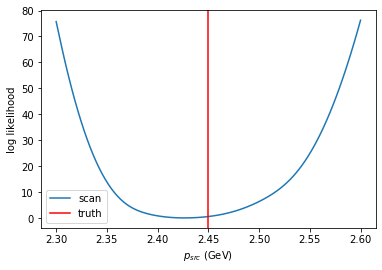

In [11]:
llh_p_scan = map_1d(ev, 1, ps, z_toy, p_toy, phi_toy)

plot_1d_scan(llh_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

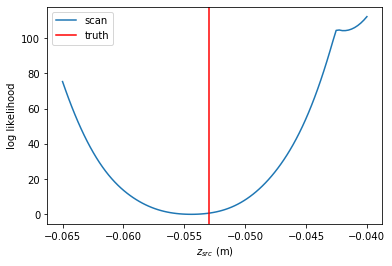

In [14]:
llh_z_scan = map_1d(ev, 0, zs, z_toy, p_toy, phi_toy)

plot_1d_scan(llh_z_scan, zs, z_toy, '$z_{src}$ (m)')

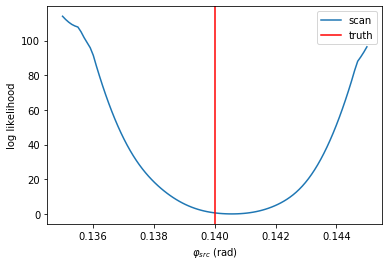

In [15]:
llh_phi_scan = map_1d(ev, 2, phis, z_toy, p_toy, phi_toy)

plot_1d_scan(llh_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

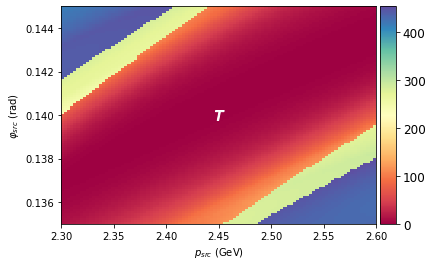

In [17]:
llh_p_phi_scan = map_2d(ev, (1, 2), (ps, phis),z_toy,p_toy,phi_toy)

plot_2d_scan(llh_p_phi_scan, ps, phis, p_toy, phi_toy,
                   axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'],log=False)

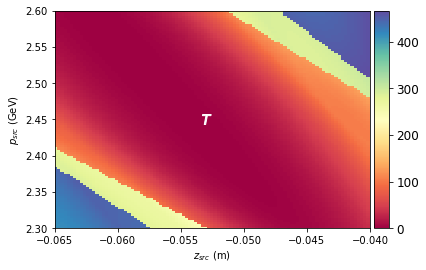

In [18]:
llh_z_p_scan = map_2d(ev, (0, 1), (zs,ps),z_toy,p_toy,phi_toy)

plot_2d_scan(llh_z_p_scan, zs,ps,z_toy, p_toy,
                   axis_labels=['$z_{src}$ (m)','$p_{src}$ (GeV)'],log=False)

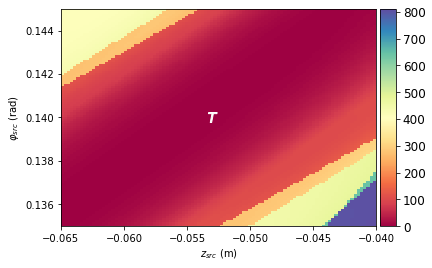

In [19]:
llh_z_phi_scan = map_2d(ev, (0, 2), (zs,phis),z_toy,p_toy,phi_toy)

plot_2d_scan(llh_z_phi_scan, zs,phis,z_toy, phi_toy,
                   axis_labels=['$z_{src}$ (m)',r'$\varphi_{src}$ (rad)'],log=False)

In [34]:
N_mc = 100000
mc, truth = MC_events(N_mc,zlims=(-0.065,-0.04),plims=(2.3,2.6),phi_lims=(0.1,0.2))

In [35]:
#neural nets

hitnet = types.SimpleNamespace() 

hitnet.events = mc

hitnet.events = np.concatenate(hitnet.events)
hitnet.events = np.vstack((hitnet.events,np.tile(det_zs,N_mc))).T

hitnet.truth = np.repeat(truth, N_det, axis=0)

assert hitnet.events.shape[0] == hitnet.truth.shape[0]

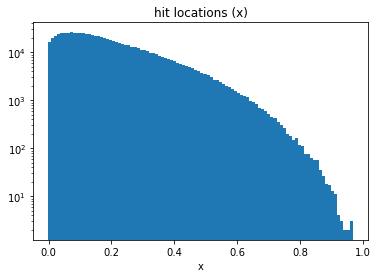

In [19]:
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit locations (x)')
plt.xlabel('x')
plt.show()

In [36]:
def make_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)



In [37]:
class trafo(tf.keras.layers.Layer):

    def call(self, hits, theta):
        #d = hits[:,1]-theta[:,0]
        #px = theta[:,1]*tf.math.sin(theta[:,2])
        #pz = theta[:,1]*tf.math.cos(theta[:,2])
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #d,
                 #px,
                 #pz,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

#add px, pz in trafo?

#class trafo(tf.keras.layers.Layer):
#    def call(self, hits, theta):
#        locs = detector_loc(N_det)
#        r2 = tf.math.square(locs - tf.reshape(theta[:,0],[-1,1])) + tf.math.square(tf.reshape(theta[:,1],[-1,1]))
#        out = tf.concat([hits,r2,theta],axis=1)
        #out = tf.concat([hits,theta],axis=1)
#        return out
    
hitnet.trafo = trafo

In [38]:
## charge net

hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)
hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)


#hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=5)

In [61]:
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(128, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(16, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(8, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_3 (trafo)                 (None, 5)            0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 32)           192         trafo_3[0][0]              

In [62]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [66]:
#n_epochs = 5
#for i in range(n_epochs):
#    hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
#    hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)
#    hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=1, verbose=1, validation_data=hitnet.d_test)

hitnet.hist = hitnet.model.fit(hitnet.d_train, epochs=10, verbose=1, validation_data=hitnet.d_test)

Epoch 1/10
313/313 [==============================] - 16s 50ms/step - loss: 0.4111 - val_loss: 0.4098
Epoch 2/10
313/313 [==============================] - 16s 53ms/step - loss: 0.4063 - val_loss: 0.4043
Epoch 3/10
313/313 [==============================] - 16s 53ms/step - loss: 0.4009 - val_loss: 0.4030
Epoch 4/10
313/313 [==============================] - 17s 53ms/step - loss: 0.3967 - val_loss: 0.3944
Epoch 5/10
313/313 [==============================] - 16s 50ms/step - loss: 0.3932 - val_loss: 0.3934
Epoch 6/10
313/313 [==============================] - 15s 47ms/step - loss: 0.3888 - val_loss: 0.3871
Epoch 7/10
313/313 [==============================] - 15s 49ms/step - loss: 0.3868 - val_loss: 0.3841
Epoch 8/10
313/313 [==============================] - 16s 51ms/step - loss: 0.3836 - val_loss: 0.3825
Epoch 9/10
313/313 [==============================] - 15s 47ms/step - loss: 0.3797 - val_loss: 0.3876
Epoch 10/10
313/313 [==============================] - 15s 49ms/step - loss: 0.378

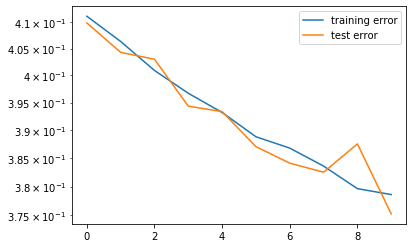

In [67]:
plt.plot(hitnet.model.history.history['loss'],label='training error')
plt.plot(hitnet.model.history.history['val_loss'],label='test error')
plt.gca().set_yscale('log')
plt.legend()
plt.show()

hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear #result is log r(x,theta)
hitnet.llh.compile()

In [32]:
def plot_1d_diff(theory, nn, xs, true_x, axis_label,scale=True):
    
    scan_a = np.copy(theory)
    scan_a -= scan_a.min()
    
    scan_b = np.copy(nn)
    scan_b -= scan_b.min()
    
    a_label='Analytic'
    if scale: 
        scan_a *= scan_b.max()/scan_a.max()
        a_label += ' (scaled)'
    
    plt.plot(xs,scan_a,label=a_label)
    plt.plot(xs,scan_b,label='Neural net')
    
    #diff = scan_a - scan_b
    
    #plt.plot(xs,diff,label='difference')
    
    plt.axvline(x=true_x,color='red',label='truth')
    plt.xlabel(axis_label)
    plt.ylabel('log likelihood')
    plt.legend()

def plot_2d_diff(theory, nn, xs, ys, true_x, true_y, axis_labels, vmax=None,scale=False, **kwargs):
    
    gridsize = xs.size
    assert ys.size==gridsize
    
    fig,ax = plt.subplots(1,3,figsize=(23,7))
    plt.subplots_adjust(wspace=0.5)
    
    scan_a = np.copy(theory).reshape(gridsize,gridsize)
    scan_a -= scan_a.min()
    
    scan_b = np.copy(nn).reshape(gridsize,gridsize)
    scan_b -= scan_b.min()
    
    scan_a *= scan_b.max()/scan_a.max()
    
    m1 = ax[0].pcolormesh(xs, ys, scan_a, cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    ax[0].set_title('Analytic (scaled)')
    ax[0].set_xlabel(axis_labels[0])
    ax[0].set_ylabel(axis_labels[1])
    colorbar(m1)
    
    m2 = ax[1].pcolormesh(xs, ys, scan_b, cmap='Spectral', rasterized=True, linewidth=0, vmin=0, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    ax[1].set_title('Neural net')
    ax[1].set_xlabel(axis_labels[0])
    ax[1].set_ylabel(axis_labels[1])
    colorbar(m2)
    
    diff = scan_a - scan_b
    md = ax[2].pcolormesh(xs, ys, diff, cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs)
    #md = axes[2].pcolormesh(xs, ys, diff, cmap='RdBu', vmin=-100, vmax=100, label=r'$\Delta LLH$', **kwargs)
    ax[2].set_title('diff')
    ax[2].set_xlabel(axis_labels[0])
    ax[2].set_ylabel(axis_labels[1])
    colorbar(md)
    
    for axis in ax.flatten():
        axis.plot([true_x], [true_y], marker='$T$', markersize=10, color='black')

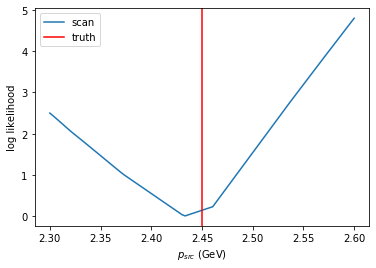

In [68]:
#ps = np.linspace(1.85,1.95,100)
#ps = np.linspace(2.4,2.5,100)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,ps,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_p_scan = hitnet.llh.predict([scan_x,scan_t])

nn_p_scan = -np.sum(nn_p_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_p_scan, ps, p_toy, axis_label='$p_{src}$ (GeV)')

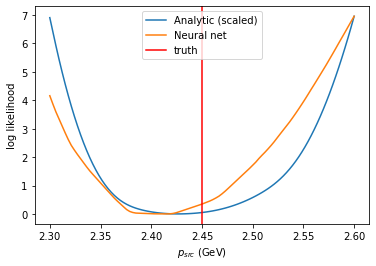

In [56]:
llh_p_scan = map_1d(ev, 1, ps, z_toy, p_toy, phi_toy)

plot_1d_diff(llh_p_scan, nn_p_scan, ps, p_toy, '$p_{src}$ (GeV)')

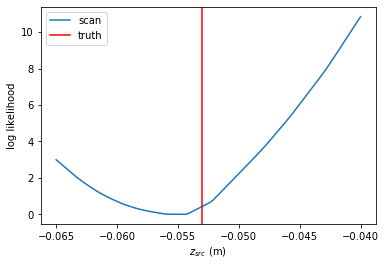

In [69]:
#zs = np.linspace(-0.22,-0.21,100)
#zs = np.linspace(-0.06,-0.05,100)

scan_t = np.vstack([zs,np.ones(grid_spacing)*p_toy,np.ones(grid_spacing)*phi_toy]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_z_scan = hitnet.llh.predict([scan_x,scan_t])

nn_z_scan = -np.sum(nn_z_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_z_scan, zs, z_toy, axis_label='$z_{src}$ (m)')

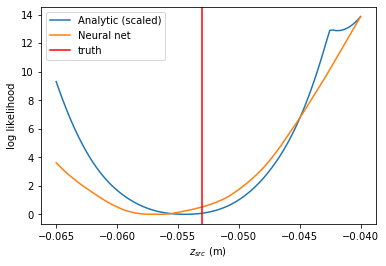

In [58]:
llh_z_scan = map_1d(ev, 0, zs, z_toy, p_toy, phi_toy)

plot_1d_diff(llh_z_scan, nn_z_scan, zs, z_toy, '$z_{src}$ (m)')

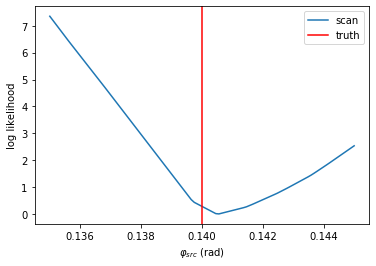

In [70]:
#phis = np.linspace(0.245,0.255,100)
#phis = np.linspace(0.135,0.145,100)

scan_t = np.vstack([np.ones(grid_spacing)*z_toy,np.ones(grid_spacing)*p_toy,phis]).T
scan_t = np.repeat(scan_t,N_det,axis=0)

scan_x = np.tile(ev,grid_spacing)
scan_x = np.vstack((scan_x,np.tile(det_zs,grid_spacing))).T

nn_phi_scan = hitnet.llh.predict([scan_x,scan_t])

nn_phi_scan = -np.sum(nn_phi_scan.reshape(-1,N_det),axis=1)
plot_1d_scan(nn_phi_scan, phis, phi_toy, axis_label=r'$\varphi_{src}$ (rad)')

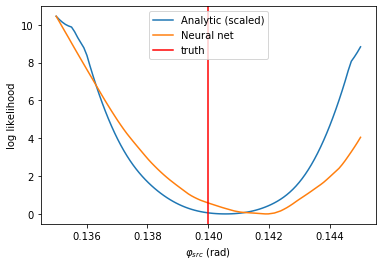

In [60]:
llh_phi_scan = map_1d(ev, 2, phis, z_toy, p_toy, phi_toy)

plot_1d_diff(llh_phi_scan, nn_phi_scan, phis, phi_toy, r'$\varphi_{src}$ (rad)')

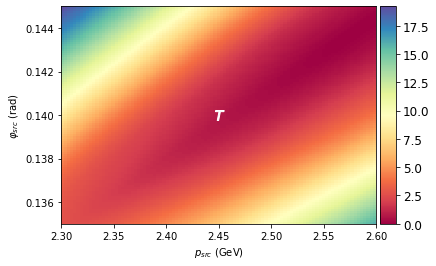

In [51]:
mg = np.meshgrid(ps,phis)

hitnet.grid_t = np.vstack([np.ones(grid_spacing**2)*z_toy,mg[0].flatten(),mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_p_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_p_phi_scan, ps, phis, p_toy, phi_toy, 
            axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'])

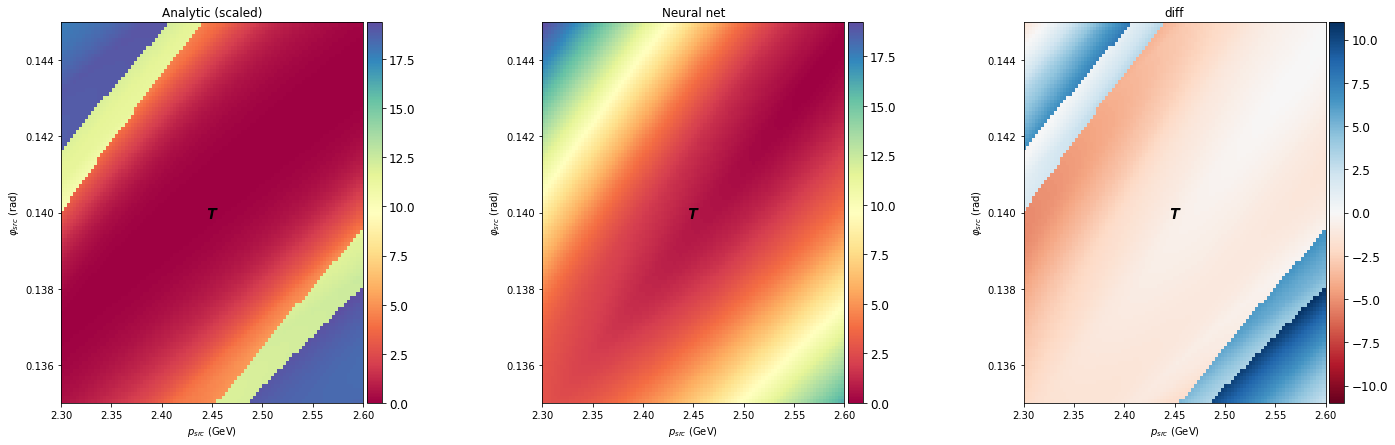

In [52]:
llh_p_phi_scan = map_2d(ev, (1, 2), (ps, phis),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_p_phi_scan, NN_p_phi_scan, ps, phis, p_toy, phi_toy,
             axis_labels=['$p_{src}$ (GeV)', r'$\varphi_{src}$ (rad)'])#,vmax=100)

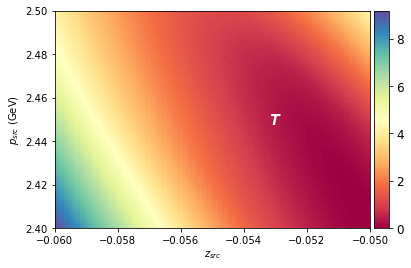

In [70]:
mg = np.meshgrid(zs,ps)

hitnet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*phi_toy]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_p_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_p_scan, zs, ps, z_toy, p_toy, 
            axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'])

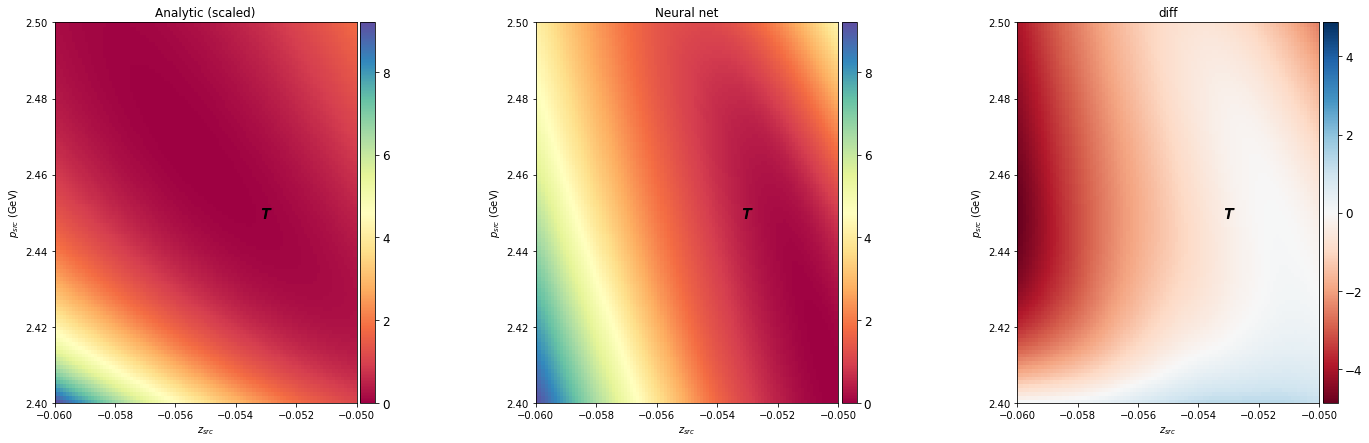

In [71]:
#llh_z_p_scan = map_2d(ev, (0, 1), (zs,ps),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_p_scan, NN_z_p_scan, zs, ps, z_toy, p_toy,
             axis_labels=['$z_{src}$', '$p_{src}$ (GeV)'])

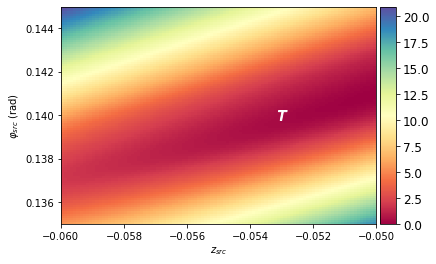

In [72]:
mg = np.meshgrid(zs,phis)

hitnet.grid_t = np.vstack([mg[0].flatten(),np.ones(grid_spacing**2)*p_toy,mg[1].flatten()]).T
hitnet.grid_t = np.repeat(hitnet.grid_t,N_det,axis=0)

hitnet.grid_x = np.tile(ev,grid_spacing**2)
hitnet.grid_x = np.vstack((hitnet.grid_x,np.tile(det_zs,grid_spacing**2))).T

hitnet.grid_llh = hitnet.llh.predict([hitnet.grid_x,hitnet.grid_t])

NN_z_phi_scan = -np.sum(hitnet.grid_llh.reshape(-1, N_det), axis=1)
plot_2d_scan(NN_z_phi_scan, zs, phis, z_toy, phi_toy, 
            axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'])

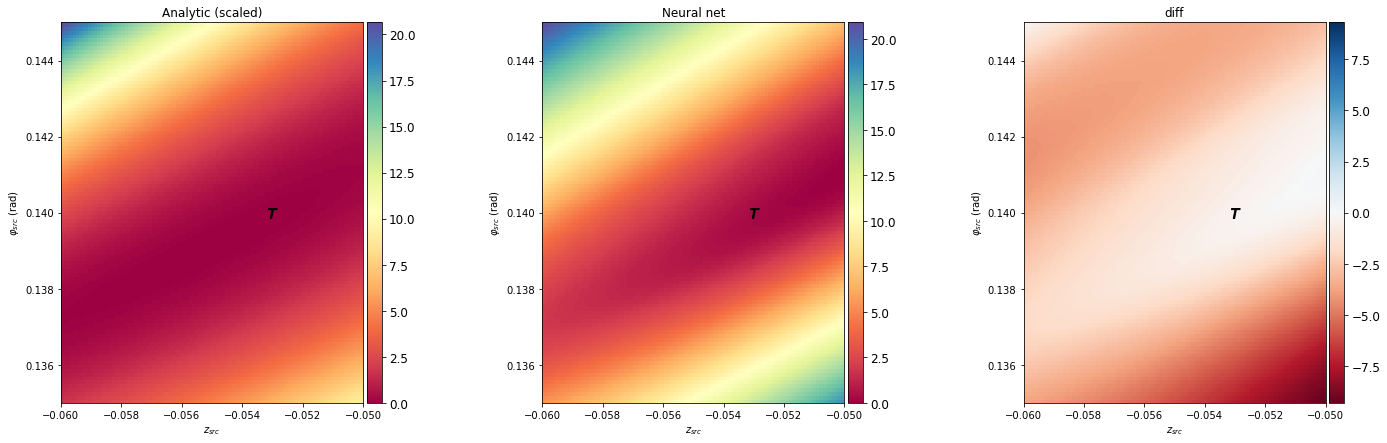

In [73]:
#llh_z_phi_scan = map_2d(ev, (0, 2), (zs,phis),z_toy,p_toy,phi_toy)

plot_2d_diff(llh_z_phi_scan, NN_z_phi_scan, zs, phis, z_toy, phi_toy,
             axis_labels=['$z_{src}$', r'$\varphi_{src}$ (rad)'])